# Task

As a data analyst there is plenty of opportunity to improve processes or suggest new ways of doing things. When doing so it is often very smart and efficient (time is a scarce resource) to create a POC (Proof of Concept) which basically is a small demo checking wether it is worthwile going further with something. It is also something concrete which facilitates discussions, do not underestimate the power of that. 

In this example, you are working in a company that sells houses and they have a "manual" process of setting prices by humans. You as a Data Scientist can make this process better by using Machine Learning. Your task is to create a POC that you will present to your team colleagues and use as a source of discussion of wether or not you should continue with more detailed modelling. 

Two quotes to facilitate your reflection on the value of creating a PoC: 

"*Premature optimization is the root of all evil*". 

"*Fail fast*".

**More specifially, do the following:**

1. A short EDA (Exploratory Data Analysis) of the housing data set.
2. Drop the column "ocean_proximity", then you only have numeric columns which will simplify your analysis. Remember, this is a POC!
3. Split your data into train and test set. 
4. Create a pipeline containing a SimpleImputer [ SimpleImputer(strategy="median") ] and a std_scaler (and fit-transform your train set). 

5. Use GridSearchCV when choosing your model. You will look at a RandomForestRegressor with 2, 5, 10 or 100 estimators. More specifically, use the following code: 

```python
param_grid = [{'n_estimators': [2, 5, 10, 100]}]

forest_reg = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(forest_reg, param_grid, cv=3,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(train_feature, train_label)
```

6. Evaluate your model on the test set using the mean squared error as the metric. Conclusions? (Remember, you have fitted your pipeline above so now you just transform your test set without fitting your pipeline on it, else it is "cheating".)

7. Do a short presentation (~ 2-5 min) on your POC that you present to your colleagues (no need to prepare anything particular, just talk from the code). Think of:
- What do you want to highlight/present?
- What is your conclusion?
- What could be the next step? Is the POC convincing enough or is it not worthwile continuing? Do we need to dig deeper into this before taking some decisions?

# POC

In [234]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn ###############################

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit


from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

In [235]:
# Below, set your own path where you have stored the data file. 
housing = pd.read_csv(r'C:\Users\Bananberg\datasets\housing\housing.csv')

## EDA

In [236]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Här ser vi att total bedrooms saknar värde... Eftersom detta är en Poc tänker jag att jag tar bort den columen snabbt. 

Men sparar en variabel med bedrooms så vi kan testa vad resutlatet blir om vi hinner. " med eller utan bedrooms" 

In [237]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Vi skapar något visuellt för att se om det finns några uppenbara korelationer. 

C:\Users\Bananberg\AppData\Local\Temp\ipykernel_18348\2748997868.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = housing.corr()


<Axes: >

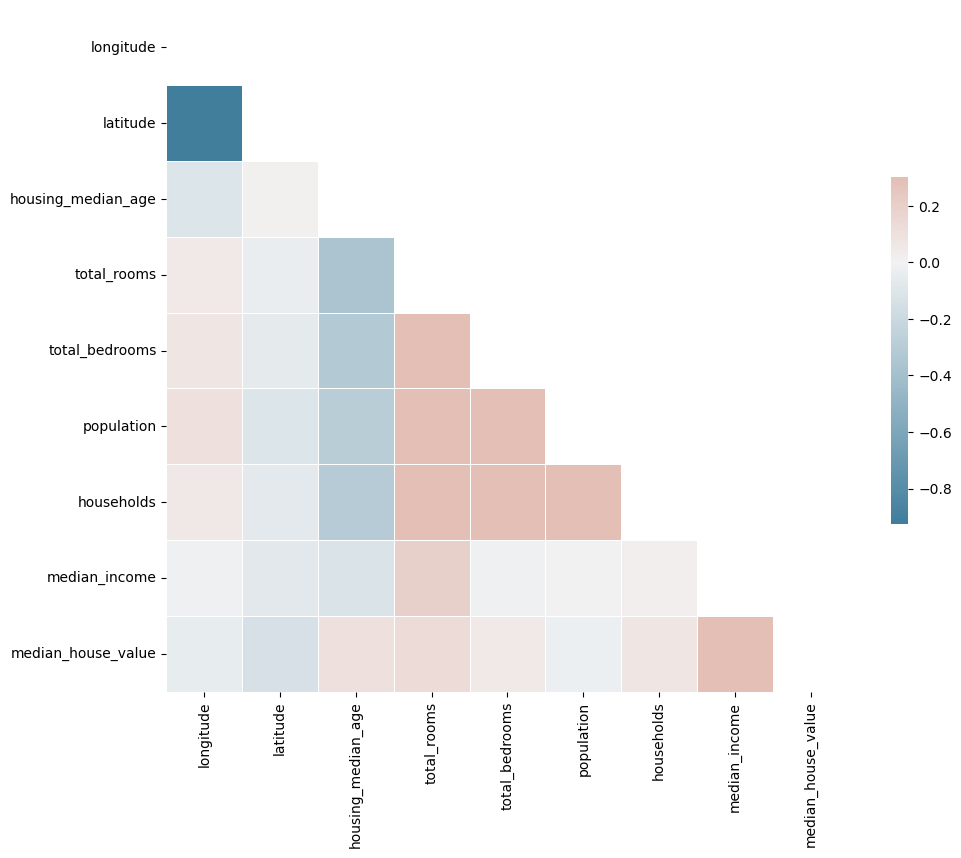

In [238]:
corr = housing.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))


f, ax = plt.subplots(figsize=(11,9))
cmap = seaborn.diverging_palette(230, 20, as_cmap=True)
seaborn.heatmap(corr,mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})


### Okej, median_house_value och median_income har stark correlation.

### De andra correlationerna är ganska självklara och inte lika interssant i en poc

<Axes: >

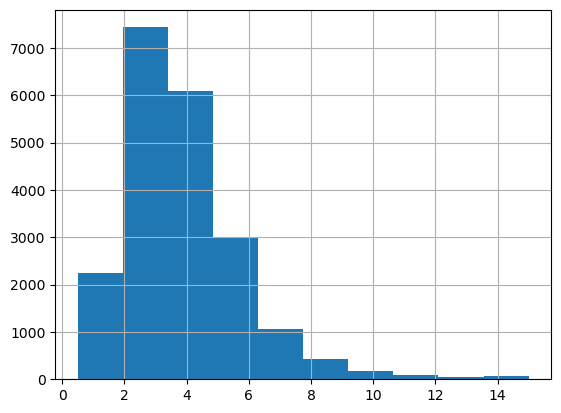

In [239]:
housing["median_income"].hist()

<Axes: >

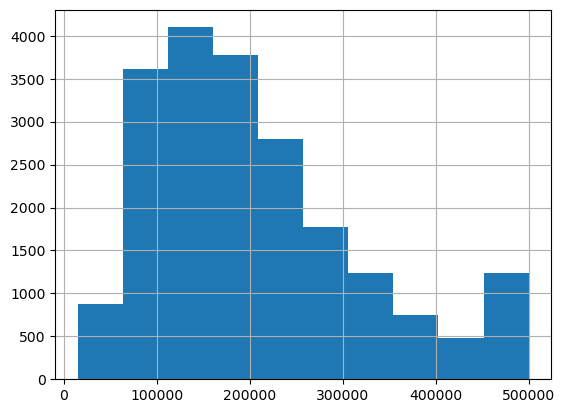

In [240]:
housing["median_house_value"].hist()

### Vi skapar några variabler som går att modellera mot varnadra och som vi splittar. 

Vi tar bort det som skänns ofullständigt och orelevant samt droppar det som inte är numeriskt för att kunna splitta datasettet.

In [241]:
housing_num = housing.drop(["ocean_proximity"], axis=1)



## Vi splittar housing . num 

In [242]:
train_set, test_set = train_test_split(housing_num, test_size=0.2, random_state=42)

## Vi tittar så splittet gick bra och är jämn

In [243]:
train_set.shape, test_set.shape

((16512, 9), (4128, 9))

## Vi delar skapar fetuers set och target set av split datan.
## samt train och test sets

In [244]:
X_train_pre = train_set.drop("median_house_value", axis=1)
y_train = train_set["median_house_value"].copy()

In [245]:
X_test_pre = test_set.drop("median_house_value", axis=1)
y_test = test_set["median_house_value"].copy()

## Vi testar att stratify split 

In [246]:
# split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
# for train_index, test_index in split.split(housing_num, housing_num):
    
#  strat_train_set = housing_num.loc[train_index]
#  strat_test_set = housing_num.loc[test_index]

In [247]:
def income_cat_proportions(data):
    return data["median_income"].value_counts() / len(data)

compare_props = pd.DataFrame({
    "housing data set": income_cat_proportions(housing_num), # the wohle data / population
    #"Stratified data set": income_cat_proportions(strat_test_set), # the 80% stratifyed test sampling 
    "manual random split": income_cat_proportions(X_train_pre), # the 80% test sampling 
}).sort_index()

compare_props

,housing data set,manual random split
0.4999,0.000581,0.000606
0.5360,0.000484,0.000606
0.5495,0.000048,0.000061
0.6433,0.000048,0.000061
0.6775,0.000048,NaN
...,...,...
14.4219,0.000048,0.000061
14.5833,0.000048,0.000061
14.9009,0.000048,0.000061
15.0000,0.000097,0.000121


# PIPLINE TIME!

In [248]:
my_pipe = Pipeline ([
        ('imputer', SimpleImputer(strategy='median')), # fixar det saknade värdet.
        ('std_scaler', StandardScaler()),
])
X_train = my_pipe.fit_transform(X_train_pre)

## Nu är datan fittad geonom pipline. 

In [249]:
X_train

array([[ 1.27258656, -1.3728112 ,  0.34849025, ...,  0.76827628,
         0.32290591, -0.326196  ],
       [ 0.70916212, -0.87669601,  1.61811813, ..., -0.09890135,
         0.6720272 , -0.03584338],
       [-0.44760309, -0.46014647, -1.95271028, ..., -0.44981806,
        -0.43046109,  0.14470145],
       ...,
       [ 0.59946887, -0.75500738,  0.58654547, ...,  0.28983345,
         0.07090859, -0.49697313],
       [-1.18553953,  0.90651045, -1.07984112, ...,  0.30830275,
         0.15490769,  0.96545045],
       [-1.41489815,  0.99543676,  1.85617335, ...,  1.04883375,
         1.94776365, -0.68544764]])

# Låt oss applicera lite modeller

In [250]:
param_grid = [{'n_estimators': [2, 5, 10, 100]}]

forest_reg = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(forest_reg, param_grid, cv=3,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'n_estimators': [2, 5, 10, 100]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [251]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.156218,0.005040,0.003223,0.000388,2,{'n_estimators': 2},-4.381116e+09,-3.972698e+09,-4.196944e+09,-4.183586e+09,1.670033e+08,4,-1.315632e+09,-1.254250e+09,-1.183058e+09,-1.250980e+09,5.417238e+07
1,0.375436,0.006097,0.009547,0.003488,5,{'n_estimators': 5},-3.301854e+09,-2.984350e+09,-3.243556e+09,-3.176586e+09,1.379999e+08,3,-7.176629e+08,-6.757194e+08,-6.857290e+08,-6.930371e+08,1.788610e+07
2,0.761810,0.010797,0.009126,0.002133,10,{'n_estimators': 10},-2.963571e+09,-2.785780e+09,-2.917142e+09,-2.888831e+09,7.529313e+07,2,-5.317911e+08,-5.141796e+08,-5.107097e+08,-5.188935e+08,9.229349e+06
3,7.679652,0.100344,0.096104,0.004352,100,{'n_estimators': 100},-2.628848e+09,-2.473381e+09,-2.584217e+09,-2.562149e+09,6.535927e+07,1,-3.658958e+08,-3.702222e+08,-3.560675e+08,-3.640618e+08,5.922344e+06


# Evaluate model on the test set

In [252]:
X_test = my_pipe.transform(X_test_pre)

In [253]:
prediction = grid_search.predict(X_test)

In [254]:
mse = mean_squared_error(y_test, prediction)
rmse = np.sqrt(mse)
rmse

49875.648686594046

In [255]:
mean_value = housing["median_house_value"].mean()
mean_value

206855.81690891474

In [256]:
rmse/ mean_value

0.24111310685817405